In [ ]:
# Install dependencies and mount drive
# ----------------------------------------------------------------------------
# Google Drive folder: https://drive.google.com/drive/folders/1rPJtDwGNKZNMJQ8hIvKxONVr_xvVzq_d
from google.colab import drive
import os

# Check if drive is already mounted
if os.path.exists('/content/drive/MyDrive'):
    print("Drive is already mounted!")
else:
    # Mount Google Drive
    # If you get an error about mountpoint containing files, run this cell again
    # or use: drive.mount('/content/drive', force_remount=True)
    drive.mount('/content/drive')

Drive is already mounted!


In [ ]:
# Import libraries
# ----------------------------------------------------------------------------
import zipfile
import re
import os
import pandas as pd
import numpy as np
from io import BytesIO

print(" Libraries imported successfully")

 Libraries imported successfully


In [ ]:
#Configuration
# ----------------------------------------------------------------------------
# MODIFY THIS PATH to match your Drive location
ZIP_PATH = "/content/drive/MyDrive/CMPE255-NIDSPROJECT/GeneratedLabelledFlows.zip"
OUTPUT_DIR = "/content/drive/MyDrive/CMPE255-NIDSPROJECT/data"

TARGET_FILES = [
    "TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",      # DDoS attacks
    "TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv",                  # Multiple DoS variants
    "TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv"                     # Mixed traffic
]

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f" Output directory: {OUTPUT_DIR}")
print(f" Will process {len(TARGET_FILES)} files")

 Output directory: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data
 Will process 3 files


In [ ]:
# Cell 4: Helper functions
# ----------------------------------------------------------------------------
def normalize_col(c: str) -> str:
    """Trim spaces, remove BOM/nbsp, collapse whitespace."""
    c = (c or "")
    c = c.replace("\ufeff", "").replace("\xa0", " ")
    c = re.sub(r"\s+", " ", c).strip()
    return c

def find_label_col(cols, name_target="label"):
    """Find Label column even if spacing/case differs."""
    for c in cols:
        if normalize_col(c).lower() == name_target.lower():
            return c
    for c in cols:
        if name_target.lower() in normalize_col(c).lower():
            return c
    return None

def is_dos_ddos(label: str) -> bool:
    """Check if label is DoS/DDoS related."""
    if pd.isna(label):
        return False
    label_lower = str(label).lower()
    dos_keywords = ['dos', 'ddos', 'hulk', 'goldeneye', 'slowloris', 'slowhttptest']
    return any(keyword in label_lower for keyword in dos_keywords)

print(" Helper functions defined")

 Helper functions defined


In [ ]:
# Cell 5: Inspect ZIP contents
# ----------------------------------------------------------------------------
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    all_csv_files = [f for f in zf.namelist() if f.lower().endswith('.csv')]

print(f" Found {len(all_csv_files)} CSV files in ZIP\n")
print("Files we'll process:")
for i, f in enumerate(TARGET_FILES, 1):
    print(f"  {i}. {f.split('/')[-1]}")


 Found 8 CSV files in ZIP

Files we'll process:
  1. Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  2. Wednesday-workingHours.pcap_ISCX.csv
  3. Tuesday-WorkingHours.pcap_ISCX.csv


In [ ]:
# Cell 6: Select target CSV file
# ----------------------------------------------------------------------------
# Prioritize files with DoS/DDoS attacks (Wednesday/Friday typically have more attacks)
print("\n" + "="*80)
print("AUTO-DETECTING FILES IN ZIP")
print("="*80)

# First, list ALL files in the ZIP to see the actual structure
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    all_files_in_zip = zf.namelist()
    csv_files_in_zip = [f for f in all_files_in_zip if f.lower().endswith('.csv')]

    print(f"✓ Found {len(csv_files_in_zip)} CSV files in ZIP:\n")
    for i, f in enumerate(csv_files_in_zip, 1):
        print(f"  {i}. {f}")

# Now match our target files with actual paths in ZIP
print("\n" + "="*80)
print("MATCHING TARGET FILES")
print("="*80)

target_keywords = [
    "Friday-WorkingHours-Afternoon-DDos",
    "Wednesday-workingHours",
    "Tuesday-WorkingHours"
]

matched_files = []
for keyword in target_keywords:
    for csv_file in csv_files_in_zip:
        if keyword.lower() in csv_file.lower():
            matched_files.append(csv_file)
            print(f"✓ Matched '{keyword}' → {csv_file}")
            break
    else:
        print(f"  Could not find file matching '{keyword}'")

print(f"\n✓ Will process {len(matched_files)} files")

# Now process the matched files
print("\n" + "="*80)
print("PROCESSING MULTIPLE CSV FILES")
print("="*80)

all_dataframes = []

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    for idx, csv_file in enumerate(matched_files, 1):
        print(f"\n{'='*80}")
        print(f" Processing File {idx}/{len(matched_files)}: {csv_file.split('/')[-1]}")
        print(f"{'='*80}")

        # Load CSV
        try:
            with zf.open(csv_file) as f:
                df_temp = pd.read_csv(f, low_memory=False)

            print(f" Loaded: {df_temp.shape[0]:,} rows × {df_temp.shape[1]} columns")

            # Normalize column names
            orig_cols = df_temp.columns.tolist()
            norm_cols = [normalize_col(c) for c in orig_cols]
            rename_map = dict(zip(orig_cols, norm_cols))
            df_temp.rename(columns=rename_map, inplace=True)

            # Add source file column for tracking
            file_name = csv_file.split('/')[-1].replace('.pcap_ISCX.csv', '')
            df_temp['source_file'] = file_name

            all_dataframes.append(df_temp)
            print(f"✓ Normalized columns and added source tracking")

        except Exception as e:
            print(f" Error loading {csv_file}: {e}")
            continue

if len(all_dataframes) == 0:
    print("\n ERROR: No files were successfully loaded!")
    print("Please check the ZIP file structure.")
else:
    print(f"\n Successfully loaded {len(all_dataframes)} files")


AUTO-DETECTING FILES IN ZIP
✓ Found 8 CSV files in ZIP:

  1. TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv
  2. TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv
  3. TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  4. TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  5. TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv
  6. TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv
  7. TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  8. TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv

MATCHING TARGET FILES
✓ Matched 'Friday-WorkingHours-Afternoon-DDos' → TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
✓ Matched 'Wednesday-workingHours' → TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv
✓ Matched 'Tuesday-WorkingHours' → TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv

✓ Will process 3 files

PROCESSING MULTIPLE CSV FILES

 Processing File 1

In [ ]:
# Cell 7: Load CSV from ZIP
# ----------------------------------------------------------------------------
print(f"\n{'='*80}")
print("COMBINING ALL DATAFRAMES")
print(f"{'='*80}")

# Safety check: ensure we have dataframes to combine
if len(all_dataframes) == 0:
    raise ValueError(" ERROR: No files were successfully loaded! Cannot proceed.")

df = pd.concat(all_dataframes, ignore_index=True)

print(f" Combined {len(all_dataframes)} files")
print(f"  Total shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show distribution by source file
print("\n Rows per source file:")
print(df['source_file'].value_counts())


COMBINING ALL DATAFRAMES
 Combined 3 files
  Total shape: 1,364,357 rows × 86 columns
  Memory usage: 1351.07 MB

 Rows per source file:
source_file
Wednesday-workingHours                692703
Tuesday-WorkingHours                  445909
Friday-WorkingHours-Afternoon-DDos    225745
Name: count, dtype: int64


CSV files, especially from different sources, often have messy column names with
extra spaces: " Label " or "Flow  Duration" , Special invisible characters: BOM (Byte Order Mark) \ufeff, non-breaking spaces \xa0 , Inconsistent spacing: "Total Fwd Packets" vs "Total  Fwd  Packets"
These issues cause problems when you try to access columns later.
1. Get original column names - This creates a list of all column names as they currently exist in the DataFrame.
2. Normalize Each Column Name - For example , ' Source IP'→'Source IP' , 'Destination Port '→ 'Destination Port'
3. Create a Mapping Dictionary - This tells pandas: Replace old name (key) with new name (value).
4. Rename the DataFrame Columns

In [ ]:
# Cell 8: Normalize column names
# ----------------------------------------------------------------------------
print("\n Normalizing column names...")

orig_cols = df.columns.tolist()
norm_cols = [normalize_col(c) for c in orig_cols]
rename_map = dict(zip(orig_cols, norm_cols))
df.rename(columns=rename_map, inplace=True)

print(f" Column names normalized")

print("\n" + "="*80)
print("ALL COLUMN NAMES")
print("="*80)

print(f"Total columns: {len(df.columns)}\n")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")


 Normalizing column names...
 Column names normalized

ALL COLUMN NAMES
Total columns: 86

   1. Flow ID
   2. Source IP
   3. Source Port
   4. Destination IP
   5. Destination Port
   6. Protocol
   7. Timestamp
   8. Flow Duration
   9. Total Fwd Packets
  10. Total Backward Packets
  11. Total Length of Fwd Packets
  12. Total Length of Bwd Packets
  13. Fwd Packet Length Max
  14. Fwd Packet Length Min
  15. Fwd Packet Length Mean
  16. Fwd Packet Length Std
  17. Bwd Packet Length Max
  18. Bwd Packet Length Min
  19. Bwd Packet Length Mean
  20. Bwd Packet Length Std
  21. Flow Bytes/s
  22. Flow Packets/s
  23. Flow IAT Mean
  24. Flow IAT Std
  25. Flow IAT Max
  26. Flow IAT Min
  27. Fwd IAT Total
  28. Fwd IAT Mean
  29. Fwd IAT Std
  30. Fwd IAT Max
  31. Fwd IAT Min
  32. Bwd IAT Total
  33. Bwd IAT Mean
  34. Bwd IAT Std
  35. Bwd IAT Max
  36. Bwd IAT Min
  37. Fwd PSH Flags
  38. Bwd PSH Flags
  39. Fwd URG Flags
  40. Bwd URG Flags
  41. Fwd Header Length
  42. Bwd H

In [ ]:
# Quick verification cell (optional - run between Cell 8 and 9)
print(f"Total columns after normalization: {len(df.columns)}")
print(f"\n Sample of normalized columns:")
for col in df.columns[:5]:
    print(f"  '{col}' - Length: {len(col)}, Has spaces at ends: {col != col.strip()}")

print(f"\n Label column check:")
label_col = find_label_col(df.columns, "label")
if label_col:
    print(f"  Found: '{label_col}'")
else:
    print("   Not found - showing columns with 'label' in name:")
    for col in df.columns:
        if 'label' in col.lower():
            print(f"    - '{col}'")

Total columns after normalization: 86

 Sample of normalized columns:
  'Flow ID' - Length: 7, Has spaces at ends: False
  'Source IP' - Length: 9, Has spaces at ends: False
  'Source Port' - Length: 11, Has spaces at ends: False
  'Destination IP' - Length: 14, Has spaces at ends: False
  'Destination Port' - Length: 16, Has spaces at ends: False

 Label column check:
  Found: 'Label'


In [ ]:
# Cell 9: Initial data inspection
# ----------------------------------------------------------------------------
print("\n Initial Data Inspection")
print("="*80)
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData types distribution:")
print(df.dtypes.value_counts())


 Initial Data Inspection
Dataset shape: 1,364,357 rows × 86 columns
Memory usage: 1351.07 MB

Data types distribution:
int64      43
float64    37
object      6
Name: count, dtype: int64


In [ ]:
# Cell 10: Check for missing values
# ----------------------------------------------------------------------------
print("\n🔍 Checking Missing Values Across ALL Columns...")
print("="*80)

missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

if len(missing_df) > 0:
    print(f"  Found {len(missing_df)} columns with missing values:\n")
    print(missing_df.to_string(index=False))

    # Visualize missing data severity
    print("\n Missing Data Severity:")
    severe = missing_df[missing_df['Missing_Percent'] > 50]
    moderate = missing_df[(missing_df['Missing_Percent'] > 10) & (missing_df['Missing_Percent'] <= 50)]
    minor = missing_df[missing_df['Missing_Percent'] <= 10]

    print(f"   Severe (>50%): {len(severe)} columns")
    print(f"   Moderate (10-50%): {len(moderate)} columns")
    print(f"   Minor (<10%): {len(minor)} columns")
else:
    print(" No missing values found!")


🔍 Checking Missing Values Across ALL Columns...
  Found 1 columns with missing values:

      Column  Missing_Count  Missing_Percent
Flow Bytes/s           1213         0.088906

 Missing Data Severity:
   Severe (>50%): 0 columns
   Moderate (10-50%): 0 columns
   Minor (<10%): 1 columns


In [ ]:
# Cell 11: Handle missing values
# ----------------------------------------------------------------------------
print("\n  Handling Missing Values...")
print("="*80)

initial_rows = len(df)
initial_cols = len(df.columns)

# Strategy 1: Drop columns with >50% missing values
high_missing_cols = missing_df[missing_df['Missing_Percent'] > 50]['Column'].tolist()
if high_missing_cols:
    print(f"\n Dropping {len(high_missing_cols)} columns with >50% missing:")
    for col in high_missing_cols:
        pct = missing_df[missing_df['Column'] == col]['Missing_Percent'].values[0]
        print(f"  - {col} ({pct:.1f}% missing)")
    df.drop(columns=high_missing_cols, inplace=True)

# Strategy 2: For remaining columns with missing values
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

if len(remaining_missing) > 0:
    print(f"\n Handling {len(remaining_missing)} columns with moderate/minor missing values:")

    for col in remaining_missing.index:
        missing_count = remaining_missing[col]
        missing_pct = (missing_count / len(df)) * 100

        if df[col].dtype in ['float64', 'int64']:
            # Fill numeric columns with median (using proper assignment to avoid FutureWarning)
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  ✓ {col}: Filled with median {median_val:.2f} ({missing_pct:.2f}% missing)")
        else:
            # For non-numeric, drop rows if <1%, else fill with 'Unknown'
            if missing_pct < 1.0:
                df.dropna(subset=[col], inplace=True)
                print(f"   {col}: Dropped {missing_count} rows ({missing_pct:.3f}% missing)")
            else:
                df[col].fillna('Unknown', inplace=True)
                print(f"   {col}: Filled with 'Unknown' ({missing_pct:.2f}% missing)")

print(f"\n Missing value handling complete")
print(f"  Rows: {initial_rows:,} → {len(df):,} ({initial_rows - len(df):,} removed)")
print(f"  Columns: {initial_cols} → {len(df.columns)} ({initial_cols - len(df.columns)} removed)")



  Handling Missing Values...

 Handling 1 columns with moderate/minor missing values:
  ✓ Flow Bytes/s: Filled with median 1039.09 (0.09% missing)

 Missing value handling complete
  Rows: 1,364,357 → 1,364,357 (0 removed)
  Columns: 86 → 86 (0 removed)


In [ ]:
## Cell 12: Check for duplicate rows with diagnostics
# ----------------------------------------------------------------------------
print("\n🔍 Checking for Duplicate Rows...")
print("="*80)

initial_rows = len(df)

# Exclude identifier columns that should be unique
exclude_cols = ['Flow ID', 'Timestamp', 'source_file']
cols_to_check = [c for c in df.columns if c not in exclude_cols]

print(f"Total columns in dataset: {len(df.columns)}")
print(f"Checking duplicates on: {len(cols_to_check)} feature columns")
print(f"Excluded from check: {', '.join(exclude_cols)}")

# === DIAGNOSTIC: Check column types ===
print("\n Data Type Distribution in Columns Being Checked:")
dtype_counts = df[cols_to_check].dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  • {dtype}: {count} columns")

# === Try 1: Check with exact matching (including float precision) ===
print("\n Attempt 1: Exact matching (including float precision)...")
duplicate_count_exact = df.duplicated(subset=cols_to_check).sum()
print(f"  Duplicates found: {duplicate_count_exact:,} ({duplicate_count_exact/initial_rows*100:.2f}%)")

# === Try 2: Round float columns to reduce precision sensitivity ===
print("\n Attempt 2: Rounding floats to 6 decimals (ML-friendly precision)...")
df_temp = df.copy()
float_cols = df_temp[cols_to_check].select_dtypes(include=['float64']).columns.tolist()
print(f"  Rounding {len(float_cols)} float columns...")

for col in float_cols:
    df_temp[col] = df_temp[col].round(6)

duplicate_count_rounded = df_temp.duplicated(subset=cols_to_check).sum()
print(f"  Duplicates found after rounding: {duplicate_count_rounded:,} ({duplicate_count_rounded/initial_rows*100:.2f}%)")

# === Decision: Use the rounded approach if it finds more duplicates ===
if duplicate_count_rounded > duplicate_count_exact:
    print("\n Using rounded approach (more appropriate for ML)")
    duplicate_count = duplicate_count_rounded
    # Apply rounding to original dataframe
    for col in float_cols:
        df[col] = df[col].round(6)
    print(f"  Applied rounding to {len(float_cols)} float columns in main dataframe")
else:
    print("\n✓ Using exact matching (rounding didn't find additional duplicates)")
    duplicate_count = duplicate_count_exact

# === Process duplicates ===
print(f"\n{'='*80}")
print(f"FINAL RESULT: {duplicate_count:,} duplicates ({duplicate_count/initial_rows*100:.2f}%)")
print(f"{'='*80}")

if duplicate_count > 0:
    print("\n Sample duplicate rows (showing key features + timestamps):")
    duplicates_mask = df.duplicated(subset=cols_to_check, keep=False)
    duplicates = df[duplicates_mask]

    # Show key columns
    display_cols = [c for c in ['Timestamp', 'Flow ID', 'Source IP', 'Destination IP',
                                  'Source Port', 'Destination Port', 'Protocol',
                                  'Flow Duration', 'Total Fwd Packets',
                                  'Total Backward Packets', 'Label', 'source_file']
                    if c in df.columns]
    print(duplicates[display_cols].head(10).to_string())

    # Verify: Check if duplicates have different timestamps
    if 'Timestamp' in df.columns:
        dup_groups = duplicates.groupby(cols_to_check)['Timestamp'].nunique()
        same_timestamp_groups = (dup_groups == 1).sum()
        diff_timestamp_groups = (dup_groups > 1).sum()

        print(f"\n Duplicate Analysis:")
        print(f"   Groups with SAME timestamp: {same_timestamp_groups} (likely data errors)")
        print(f"   Groups with DIFFERENT timestamps: {diff_timestamp_groups} (repeated flow patterns)")

    # Remove duplicates
    print(f"\n  Removing duplicates (keeping first occurrence)...")
    df.drop_duplicates(subset=cols_to_check, inplace=True, keep='first')
    print(f" Removed {duplicate_count:,} duplicate rows")
    print(f"  Rationale: Feature-identical flows are redundant for ML training")
    print(f"  Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
else:
    print("\n Analysis: Zero duplicates could mean:")
    print("  1. CIC IDS 2017 has genuinely unique flows (high-quality dataset)")
    print("  2. Timestamp/Flow ID variations make each row unique")
    print("  3. High float precision creates artificial uniqueness")
    print("\n Proceeding with full dataset - no duplicates to remove")
    print(f"  Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")


🔍 Checking for Duplicate Rows...
Total columns in dataset: 86
Checking duplicates on: 83 feature columns
Excluded from check: Flow ID, Timestamp, source_file

 Data Type Distribution in Columns Being Checked:
  • int64: 43 columns
  • float64: 37 columns
  • object: 3 columns

 Attempt 1: Exact matching (including float precision)...
  Duplicates found: 9,880 (0.72%)

 Attempt 2: Rounding floats to 6 decimals (ML-friendly precision)...
  Rounding 37 float columns...
  Duplicates found after rounding: 9,880 (0.72%)

✓ Using exact matching (rounding didn't find additional duplicates)

FINAL RESULT: 9,880 duplicates (0.72%)

 Sample duplicate rows (showing key features + timestamps):
          Timestamp                                  Flow ID      Source IP  Destination IP  Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets   Label                         source_file
405   7/7/2017 3:30  192.168.10.255-192.168.10.17-137-137-17  192.168.10.1

In [ ]:
# Cell 13: Verify label column and display distribution
# ----------------------------------------------------------------------------
print("\n  Label Distribution Analysis")
print("="*80)

label_col = find_label_col(df.columns, "label")

if label_col:
    print(f" Found label column: '{label_col}'\n")

    # Overall label distribution
    label_counts = df[label_col].value_counts()
    print("All labels in dataset:")
    for label, count in label_counts.items():
        pct = count / len(df) * 100
        is_dos = " DoS/DDoS" if is_dos_ddos(label) else ""
        print(f"  {label:40s}: {count:10,} ({pct:6.2f}%) {is_dos}")

    # DoS/DDoS specific count
    dos_count = df[label_col].apply(is_dos_ddos).sum()
    benign_count = df[label_col].str.strip().str.lower().eq('benign').sum()

    print(f"\n Attack Type Summary:")
    print(f"   DoS/DDoS: {dos_count:,} ({dos_count/len(df)*100:.2f}%)")
    print(f"   BENIGN: {benign_count:,} ({benign_count/len(df)*100:.2f}%)")
    print(f"   Other attacks: {len(df) - dos_count - benign_count:,}")

    # Distribution by source file
    print(f"\n Label distribution by source file:")
    file_label_dist = pd.crosstab(df['source_file'], df[label_col])
    print(file_label_dist)

else:
    print("  No label column found!")
    print("Available columns:", df.columns.tolist())


  Label Distribution Analysis
 Found label column: 'Label'

All labels in dataset:
  BENIGN                                  :    967,555 ( 71.43%) 
  DoS Hulk                                :    223,488 ( 16.50%)  DoS/DDoS
  DDoS                                    :    128,027 (  9.45%)  DoS/DDoS
  DoS GoldenEye                           :     10,293 (  0.76%)  DoS/DDoS
  FTP-Patator                             :      7,938 (  0.59%) 
  SSH-Patator                             :      5,897 (  0.44%) 
  DoS slowloris                           :      5,769 (  0.43%)  DoS/DDoS
  DoS Slowhttptest                        :      5,499 (  0.41%)  DoS/DDoS
  Heartbleed                              :         11 (  0.00%) 

 Attack Type Summary:
   DoS/DDoS: 373,076 (27.54%)
   BENIGN: 967,555 (71.43%)
   Other attacks: 13,846

 Label distribution by source file:
Label                               BENIGN    DDoS  DoS GoldenEye  DoS Hulk  \
source_file                                            

In [ ]:
# Cell 14: Save cleaned data (Step 1 complete)
# ----------------------------------------------------------------------------
print("\n Saving Cleaned Data (Missing & Duplicates Handled)...")
print("="*80)

# Dynamic filename based on number of files processed
num_files = df['source_file'].nunique()
output_file = os.path.join(OUTPUT_DIR, f"step1_cleaned_combined_{num_files}files.parquet")
df.to_parquet(output_file, index=False, engine='pyarrow', compression='snappy')

print(f" Saved to: {output_file}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

file_size_mb = os.path.getsize(output_file) / 1024**2
print(f"  File size: {file_size_mb:.2f} MB")

# Also save a metadata summary
metadata = {
    'files_processed': matched_files,
    'total_rows': len(df),
    'total_columns': len(df.columns),
    'source_distribution': df['source_file'].value_counts().to_dict()
}
metadata_file = os.path.join(OUTPUT_DIR, f"step1_metadata_{num_files}files.txt")
with open(metadata_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PREPROCESSING STEP 1 METADATA\n")
    f.write("="*80 + "\n\n")
    f.write(f"Files Processed:\n")
    for i, file in enumerate(metadata['files_processed'], 1):
        f.write(f"  {i}. {file}\n")
    f.write(f"\nTotal Rows: {metadata['total_rows']:,}\n")
    f.write(f"Total Columns: {metadata['total_columns']}\n")
    f.write(f"\nRows per Source File:\n")
    for source, count in metadata['source_distribution'].items():
        f.write(f"  {source}: {count:,}\n")

print(f" Saved metadata to: {metadata_file}")



 Saving Cleaned Data (Missing & Duplicates Handled)...
 Saved to: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step1_cleaned_combined_3files.parquet
  Shape: 1,354,477 rows × 86 columns
  File size: 181.27 MB
 Saved metadata to: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step1_metadata_3files.txt


 Saved interim output as Parquet for:
1. Fast reload if Colab disconnects (avoid re-running 10+ min cleaning)
2. Parquet = 60% smaller + 10x faster than CSV + preserves data types
3. Reproducibility - versioned checkpoints for each preprocessing step
4. Experimentation - try different approaches on same clean baseline
5. Best practice - industry standard for ML pipelines

In [ ]:
# Cell 15: Summary statistics
# ----------------------------------------------------------------------------
print("\n Final Dataset Summary (Step 1 Complete)")
print("="*80)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Files combined: {df['source_file'].nunique()}")
print(f"Files: {', '.join(df['source_file'].unique())}")
print(f"\nNumeric columns summary:")
print(df.describe())

print("\n Step 1 Complete: Missing values and duplicates handled!")
print(f" Combined {len(matched_files)} CSV files focused on DoS/DDoS attacks")
print("Next step: Outlier detection and feature engineering")


 Final Dataset Summary (Step 1 Complete)
Total rows: 1,354,477
Total columns: 86
Files combined: 3
Files: Friday-WorkingHours-Afternoon-DDos, Wednesday-workingHours, Tuesday-WorkingHours

Numeric columns summary:
        Source Port  Destination Port      Protocol  Flow Duration  \
count  1.354477e+06      1.354477e+06  1.354477e+06   1.354477e+06   
mean   4.119804e+04      7.308700e+03  9.517292e+00   2.057618e+07   
std    2.172930e+04      1.786470e+04  5.135087e+00   3.805836e+07   
min    0.000000e+00      0.000000e+00  0.000000e+00  -4.000000e+00   
25%    3.291600e+04      5.300000e+01  6.000000e+00   2.280000e+02   
50%    5.064500e+04      8.000000e+01  6.000000e+00   6.943300e+04   
75%    5.791000e+04      4.430000e+02  1.700000e+01   9.332258e+06   
max    6.553500e+04      6.553200e+04  1.700000e+01   1.200000e+08   

       Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
count       1.354477e+06            1.354477e+06                 1.354477e

In [ ]:
# Outlier detection and Removal - Import libraries and load Step 1 output
import pandas as pd
import numpy as np

data_dir = '/content/drive/MyDrive/CMPE255-NIDSPROJECT/data'
print(f"Checking directory: {data_dir}")


print("\n" + "="*80)
print("STEP 2: OUTLIER DETECTION & REMOVAL")
print("="*80)

print("\n Loading Step 1 cleaned data...")
df = pd.read_parquet('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step1_cleaned_combined_3files.parquet')

print(f" Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

initial_rows = len(df)

Checking directory: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data

STEP 2: OUTLIER DETECTION & REMOVAL

 Loading Step 1 cleaned data...
 Loaded: 1,354,477 rows × 86 columns
Memory usage: 1341.30 MB


In [ ]:
#Identify numeric columns for outlier detection
print("\n" + "="*80)
print("IDENTIFYING NUMERIC COLUMNS")
print("="*80)

# Get numeric columns (exclude ID, timestamp, categorical)
exclude_cols = ['Flow ID', 'Timestamp', 'Source IP', 'Destination IP', 'Label', 'source_file']
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Total numeric columns for outlier detection: {len(numeric_cols)}")
print(f"\nFirst 15 numeric columns:")
for i, col in enumerate(numeric_cols[:15], 1):
    print(f"  {i:2d}. {col}")


IDENTIFYING NUMERIC COLUMNS
Total numeric columns for outlier detection: 80

First 15 numeric columns:
   1. Source Port
   2. Destination Port
   3. Protocol
   4. Flow Duration
   5. Total Fwd Packets
   6. Total Backward Packets
   7. Total Length of Fwd Packets
   8. Total Length of Bwd Packets
   9. Fwd Packet Length Max
  10. Fwd Packet Length Min
  11. Fwd Packet Length Mean
  12. Fwd Packet Length Std
  13. Bwd Packet Length Max
  14. Bwd Packet Length Min
  15. Bwd Packet Length Mean


In [ ]:
#Detect and fix negative values <<TBD>>
import pandas as pd
import numpy as np
import os

print("\n" + "="*80)
print("STEP 2: OUTLIER DETECTION & REMOVAL")
print("="*80)

print("\n Loading Step 1 cleaned data...")
df = pd.read_parquet('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step1_cleaned_combined_3files.parquet')

print(f" Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

initial_rows = len(df)

print("\n" + "="*80)
print("STEP 2.1: DETECTING DOMAIN VIOLATIONS (Negative Values)")
print("="*80)

# Features that CANNOT be negative (domain knowledge)
must_be_positive = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s',
    'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
    'min_seg_size_forward', 'Active Mean', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Max', 'Idle Min'
]

# Find columns that exist in dataframe
must_be_positive = [col for col in must_be_positive if col in df.columns]

print(f"Checking {len(must_be_positive)} columns that must be non-negative:\n")

negative_issues = {}
for col in must_be_positive:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        negative_issues[col] = negative_count
        negative_pct = (negative_count / len(df)) * 100
        print(f"  {col}: {negative_count:,} negative values ({negative_pct:.3f}%)")

if negative_issues:
    print(f"\n Fixing {len(negative_issues)} columns with negative values...")

    for col in negative_issues.keys():
        # Strategy: Remove rows with negative values (data quality issues)
        rows_before = len(df)
        df = df[df[col] >= 0]
        rows_removed = rows_before - len(df)
        print(f"   {col}: Removed {rows_removed:,} rows")

    print(f"\n Domain violations fixed")
    print(f"  Rows: {initial_rows:,} → {len(df):,} ({initial_rows - len(df):,} removed)")
else:
    print("\n No negative values found in columns that must be positive!")



STEP 2: OUTLIER DETECTION & REMOVAL

 Loading Step 1 cleaned data...
 Loaded: 1,354,477 rows × 86 columns
Memory usage: 1341.30 MB

STEP 2.1: DETECTING DOMAIN VIOLATIONS (Negative Values)
Checking 23 columns that must be non-negative:

  Flow Duration: 40 negative values (0.003%)
  Flow Bytes/s: 18 negative values (0.001%)
  Flow Packets/s: 40 negative values (0.003%)
  min_seg_size_forward: 12 negative values (0.001%)

 Fixing 4 columns with negative values...
   Flow Duration: Removed 40 rows
   Flow Bytes/s: Removed 0 rows
   Flow Packets/s: Removed 0 rows
   min_seg_size_forward: Removed 12 rows

 Domain violations fixed
  Rows: 1,354,477 → 1,354,425 (52 removed)


In [ ]:
#Detect zero-duration flows <<TBD>>
#A zero-duration flow is a network connection
#where the time difference between the first and last packet is 0 microseconds (or effectively 0).
print("\n" + "="*80)
print("STEP 2.2: HANDLING ZERO-DURATION FLOWS")
print("="*80)

if 'Flow Duration' in df.columns:
    zero_duration = (df['Flow Duration'] == 0).sum()
    zero_duration_pct = (zero_duration / len(df)) * 100

    print(f"Zero-duration flows: {zero_duration:,} ({zero_duration_pct:.2f}%)")

    if zero_duration > 0:
        print("\n Analyzing zero-duration flows:")
        zero_flows = df[df['Flow Duration'] == 0]

        # Check if they have packets
        if 'Total Fwd Packets' in df.columns and 'Total Backward Packets' in df.columns:
            zero_with_packets = ((zero_flows['Total Fwd Packets'] > 0) |
                                 (zero_flows['Total Backward Packets'] > 0)).sum()
            print(f"   With packets: {zero_with_packets:,}")
            print(f"   Without packets: {zero_duration - zero_with_packets:,}")

        # Decision: Remove zero-duration flows (problematic for rate calculations)
        print("\n  Removing zero-duration flows (causes division by zero issues)...")
        rows_before = len(df)
        df = df[df['Flow Duration'] > 0]
        rows_removed = rows_before - len(df)
        print(f"  Removed {rows_removed:,} zero-duration flows")
        print(f"  Rows: {rows_before:,} → {len(df):,}")
else:
    print("  Flow Duration column not found")


STEP 2.2: HANDLING ZERO-DURATION FLOWS
Zero-duration flows: 1,570 (0.12%)

 Analyzing zero-duration flows:
   With packets: 1,570
   Without packets: 0

  Removing zero-duration flows (causes division by zero issues)...
  Removed 1,570 zero-duration flows
  Rows: 1,354,425 → 1,352,855


In [ ]:
# outlier detection using IQR method <<TBD>>
print("\n" + "="*80)
print("STEP 2.3: STATISTICAL OUTLIER DETECTION (IQR Method)")
print("="*80)

print("Using IQR (Interquartile Range) method to detect extreme outliers")
print("Outliers defined as: values < Q1 - 3*IQR or values > Q3 + 3*IQR")
print("(Using 3*IQR instead of 1.5*IQR to be less aggressive)\n")

outlier_summary = []

for col in numeric_cols:
    if col not in df.columns:
        continue

    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds (3*IQR for less aggressive removal)
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Count outliers
    outliers_lower = (df[col] < lower_bound).sum()
    outliers_upper = (df[col] > upper_bound).sum()
    total_outliers = outliers_lower + outliers_upper

    if total_outliers > 0:
        outlier_pct = (total_outliers / len(df)) * 100
        outlier_summary.append({
            'Column': col,
            'Outliers': total_outliers,
            'Percentage': outlier_pct,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Q1': Q1,
            'Q3': Q3
        })

# Convert to DataFrame and sort by percentage
outlier_df = pd.DataFrame(outlier_summary).sort_values('Percentage', ascending=False)

print(f" Columns with outliers (top 20):\n")
if len(outlier_df) > 0:
    display_df = outlier_df.head(20).copy()
    display_df['Percentage'] = display_df['Percentage'].apply(lambda x: f"{x:.2f}%")
    print(display_df[['Column', 'Outliers', 'Percentage']].to_string(index=False))
else:
    print(" No statistical outliers detected!")



STEP 2.3: STATISTICAL OUTLIER DETECTION (IQR Method)
Using IQR (Interquartile Range) method to detect extreme outliers
Outliers defined as: values < Q1 - 3*IQR or values > Q3 + 3*IQR
(Using 3*IQR instead of 1.5*IQR to be less aggressive)

 Columns with outliers (top 20):

                Column  Outliers Percentage
            Active Min    335417     24.79%
            Active Max    332297     24.56%
           Active Mean    332254     24.56%
        PSH Flag Count    321621     23.77%
         Fwd IAT Total    289375     21.39%
          Flow Bytes/s    284870     21.06%
         Flow Duration    283972     20.99%
         Bwd Packets/s    281952     20.84%
           Bwd IAT Max    281456     20.80%
          Bwd IAT Mean    274297     20.28%
         Bwd IAT Total    272398     20.14%
Packet Length Variance    264638     19.56%
           Bwd IAT Std    262271     19.39%
           Fwd IAT Min    245841     18.17%
          Fwd IAT Mean    224686     16.61%
          Flow IAT Min

In [ ]:
# Remove extreme outliers <<TBD>>
print("\n" + "="*80)
print("STEP 2.4: REMOVING EXTREME OUTLIERS")
print("="*80)

rows_before_outlier_removal = len(df)

# Strategy: Mark rows with outliers in critical columns only
# Not all columns - focus on flow characteristics that matter most for DoS/DDoS

critical_cols = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Flow Bytes/s', 'Flow Packets/s'
]
critical_cols = [col for col in critical_cols if col in df.columns]

print(f"Removing outliers from {len(critical_cols)} critical columns:")
for col in critical_cols:
    print(f"   {col}")

outlier_mask = pd.Series([False] * len(df), index=df.index)

for col in critical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Mark rows with outliers
    col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask = outlier_mask | col_outliers

    if col_outliers.sum() > 0:
        print(f"  {col}: {col_outliers.sum():,} outliers")

# Remove rows marked as outliers
df = df[~outlier_mask]
rows_removed = rows_before_outlier_removal - len(df)
removal_pct = (rows_removed / rows_before_outlier_removal) * 100

print(f"\n Outlier removal complete")
print(f"  Removed: {rows_removed:,} rows ({removal_pct:.2f}%)")
print(f"  Remaining: {len(df):,} rows")



STEP 2.4: REMOVING EXTREME OUTLIERS
Removing outliers from 7 critical columns:
   Flow Duration
   Total Fwd Packets
   Total Backward Packets
   Total Length of Fwd Packets
   Total Length of Bwd Packets
   Flow Bytes/s
   Flow Packets/s
  Flow Duration: 283,972 outliers
  Total Fwd Packets: 66,507 outliers
  Total Backward Packets: 47,248 outliers
  Total Length of Fwd Packets: 99,218 outliers
  Total Length of Bwd Packets: 33,437 outliers
  Flow Bytes/s: 284,870 outliers
  Flow Packets/s: 116,355 outliers

 Outlier removal complete
  Removed: 682,156 rows (50.42%)
  Remaining: 670,699 rows


In [ ]:
#Validate data ranges (domain constraints)
print("\n" + "="*80)
print("STEP 2.5: DOMAIN CONSTRAINT VALIDATION")
print("="*80)

print("Applying domain-specific validation rules:\n")

validation_issues = 0

# Rule 1: Ports should be 0-65535
for port_col in ['Source Port', 'Destination Port']:
    if port_col in df.columns:
        invalid_ports = ((df[port_col] < 0) | (df[port_col] > 65535)).sum()
        if invalid_ports > 0:
            print(f"  {port_col}: {invalid_ports:,} invalid values")
            df = df[(df[port_col] >= 0) & (df[port_col] <= 65535)]
            validation_issues += invalid_ports

# Rule 2: Protocol should be valid (0-255 typically)
if 'Protocol' in df.columns:
    invalid_protocol = ((df['Protocol'] < 0) | (df['Protocol'] > 255)).sum()
    if invalid_protocol > 0:
        print(f"  Protocol: {invalid_protocol:,} invalid values")
        df = df[(df['Protocol'] >= 0) & (df['Protocol'] <= 255)]
        validation_issues += invalid_protocol

# Rule 3: Packet counts should make sense
if 'Total Fwd Packets' in df.columns and 'Total Backward Packets' in df.columns:
    both_zero = ((df['Total Fwd Packets'] == 0) & (df['Total Backward Packets'] == 0)).sum()
    if both_zero > 0:
        print(f"  Flows with zero packets (both directions): {both_zero:,}")
        df = df[~((df['Total Fwd Packets'] == 0) & (df['Total Backward Packets'] == 0))]
        validation_issues += both_zero

if validation_issues > 0:
    print(f"\n Validation complete: Removed {validation_issues:,} rows with constraint violations")
else:
    print(" All domain constraints satisfied!")

print(f"  Current shape: {len(df):,} rows × {len(df.columns)} columns")



STEP 2.5: DOMAIN CONSTRAINT VALIDATION
Applying domain-specific validation rules:

 All domain constraints satisfied!
  Current shape: 670,699 rows × 86 columns


In [ ]:
#Summary statistics after outlier removal <<TBD>>
print("\n" + "="*80)
print("STEP 2 STATISTICS: BEFORE vs AFTER")
print("="*80)

print(f"\nRows removed summary:")
print(f"  Initial (Step 1 output):     {initial_rows:,}")
print(f"  After negative value removal: {len(df):,}")
print(f"  Total removed in Step 2:      {initial_rows - len(df):,} ({(initial_rows - len(df))/initial_rows*100:.2f}%)")
print(f"  Final (Step 2 output):        {len(df):,}")

# Show improved statistics for key columns
print(f"\n Key columns - statistics after cleaning:")
key_cols = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
            'Flow Bytes/s', 'Flow Packets/s']
key_cols = [col for col in key_cols if col in df.columns]

if key_cols:
    print(df[key_cols].describe())


STEP 2 STATISTICS: BEFORE vs AFTER

Rows removed summary:
  Initial (Step 1 output):     1,354,477
  After negative value removal: 670,699
  Total removed in Step 2:      683,778 (50.48%)
  Final (Step 2 output):        670,699

 Key columns - statistics after cleaning:
       Flow Duration  Total Fwd Packets  Total Backward Packets  \
count   6.706990e+05      670699.000000           670699.000000   
mean    1.965673e+06           2.988645                2.277754   
std     4.443902e+06           2.455554                2.527590   
min     3.300000e+01           1.000000                0.000000   
25%     2.404600e+04           1.000000                1.000000   
50%     6.885800e+04           2.000000                1.000000   
75%     1.357050e+06           4.000000                3.000000   
max     3.749164e+07          18.000000               21.000000   

        Flow Bytes/s  Flow Packets/s  
count  670699.000000   670699.000000  
mean     6497.095200     3591.424811  
std    

In [ ]:
#Check label distribution after outlier removal
print("\n" + "="*80)
print("LABEL DISTRIBUTION AFTER OUTLIER REMOVAL")
print("="*80)

label_col = 'Label'
if label_col in df.columns:
    print("\nLabel counts:")
    label_counts = df[label_col].value_counts()

    for label, count in label_counts.items():
        pct = count / len(df) * 100
        print(f"  {label:30s}: {count:10,} ({pct:6.2f}%)")

    # Check if we still have good representation of DoS/DDoS
    dos_keywords = ['dos', 'ddos', 'hulk', 'goldeneye', 'slowloris', 'slowhttptest']
    dos_count = df[label_col].apply(lambda x: any(k in str(x).lower() for k in dos_keywords)).sum()
    benign_count = df[label_col].str.strip().str.lower().eq('benign').sum()

    print(f"\n Attack Type Summary:")
    print(f"   DoS/DDoS: {dos_count:,} ({dos_count/len(df)*100:.2f}%)")
    print(f"   BENIGN:   {benign_count:,} ({benign_count/len(df)*100:.2f}%)")
    print(f"   Other:    {len(df) - dos_count - benign_count:,}")



LABEL DISTRIBUTION AFTER OUTLIER REMOVAL

Label counts:
  BENIGN                        :    522,004 ( 77.83%)
  DDoS                          :     89,988 ( 13.42%)
  DoS Hulk                      :     38,241 (  5.70%)
  DoS GoldenEye                 :      8,196 (  1.22%)
  FTP-Patator                   :      6,434 (  0.96%)
  SSH-Patator                   :      2,876 (  0.43%)
  DoS slowloris                 :      1,981 (  0.30%)
  DoS Slowhttptest              :        979 (  0.15%)

 Attack Type Summary:
   DoS/DDoS: 139,385 (20.78%)
   BENIGN:   522,004 (77.83%)
   Other:    9,310


In [ ]:
# Save Step 2 output
print("\n" + "="*80)
print("SAVING STEP 2 OUTPUT")
print("="*80)

output_file = os.path.join(OUTPUT_DIR, "step2_cleaned_outliers_removed.parquet")
df.to_parquet(output_file, index=False, engine='pyarrow', compression='snappy')

file_size_mb = os.path.getsize(output_file) / 1024**2

print(f" Saved to: {output_file}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  File size: {file_size_mb:.2f} MB")

# Save metadata
num_files = df['source_file'].nunique()
metadata_file = os.path.join(OUTPUT_DIR, f"step2_metadata_{num_files}files.txt")
with open(metadata_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PREPROCESSING STEP 2 METADATA\n")
    f.write("="*80 + "\n\n")
    f.write(f"Input: step1_cleaned_combined_{num_files}files.parquet\n")
    f.write(f"Output: step2_cleaned_outliers_removed.parquet\n\n")
    f.write(f"Initial Rows (Step 1): {initial_rows:,}\n")
    f.write(f"Final Rows (Step 2):   {len(df):,}\n")
    f.write(f"Rows Removed:          {initial_rows - len(df):,} ({(initial_rows - len(df))/initial_rows*100:.2f}%)\n\n")
    f.write("Outlier Removal Summary:\n")
    f.write(f"   Negative value fixes\n")
    f.write(f"   Zero-duration flow removal\n")
    f.write(f"   IQR-based outlier removal (3*IQR)\n")
    f.write(f"   Domain constraint validation\n")

print(f" Saved metadata to: {metadata_file}")

print("\n" + "="*80)
print(" STEP 2 COMPLETE: OUTLIER DETECTION & REMOVAL")
print("="*80)
print(f"Final dataset: {len(df):,} rows × {len(df.columns)} columns")
print("Ready for Step 3: Feature Engineering")


SAVING STEP 2 OUTPUT
 Saved to: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step2_cleaned_outliers_removed.parquet
  Shape: 670,699 rows × 86 columns
  File size: 86.38 MB
 Saved metadata to: /content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step2_metadata_3files.txt

 STEP 2 COMPLETE: OUTLIER DETECTION & REMOVAL
Final dataset: 670,699 rows × 86 columns
Ready for Step 3: Feature Engineering


In [ ]:
# ============================================================================
# STEP 3: FEATURE ENGINEERING
# ============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("STEP 3: FEATURE ENGINEERING")
print("="*80)

# Load Step 2 cleaned data
print("\n Loading Step 2 cleaned data...")
df = pd.read_parquet('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/step2_cleaned_outliers_removed.parquet')
print(f" Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")



STEP 3: FEATURE ENGINEERING

 Loading Step 2 cleaned data...
 Loaded: 670,699 rows × 86 columns


In [ ]:
# Step 3.1: Create binary target variable (BENIGN vs DoS/DDoS)
print("\n" + "="*80)
print("STEP 3.1: CREATING BINARY TARGET VARIABLE")
print("="*80)

def is_dos_ddos(label: str) -> bool:
    """Check if label is DoS/DDoS related."""
    if pd.isna(label):
        return False
    label_lower = str(label).lower()
    dos_keywords = ['dos', 'ddos', 'hulk', 'goldeneye', 'slowloris', 'slowhttptest']
    return any(keyword in label_lower for keyword in dos_keywords)

# Create binary target: 0 = BENIGN, 1 = DoS/DDoS
df['target'] = df['Label'].apply(lambda x: 1 if is_dos_ddos(x) else 0)

# Show distribution
print("\n Binary target distribution:")
target_counts = df['target'].value_counts()
print(f"  BENIGN (0): {target_counts[0]:,} ({target_counts[0]/len(df)*100:.2f}%)")
print(f"  DoS/DDoS (1): {target_counts[1]:,} ({target_counts[1]/len(df)*100:.2f}%)")

print("\n Original label distribution:")
print(df['Label'].value_counts())



STEP 3.1: CREATING BINARY TARGET VARIABLE

 Binary target distribution:
  BENIGN (0): 531,314 (79.22%)
  DoS/DDoS (1): 139,385 (20.78%)

 Original label distribution:
Label
BENIGN              522004
DDoS                 89988
DoS Hulk             38241
DoS GoldenEye         8196
FTP-Patator           6434
SSH-Patator           2876
DoS slowloris         1981
DoS Slowhttptest       979
Name: count, dtype: int64


In [ ]:
# Step 3.2: Select features for modeling
print("\n" + "="*80)
print("STEP 3.2: FEATURE SELECTION")
print("="*80)

# Exclude non-feature columns
exclude_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp',
                'Label', 'source_file', 'target']

# Get numeric feature columns
feature_cols = [col for col in df.columns
                if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]

print(f"Selected {len(feature_cols)} numeric features for modeling")

# Create feature matrix and target
X = df[feature_cols].copy()
y = df['target'].copy()

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

# Check for any remaining missing values
if X.isnull().sum().sum() > 0:
    print("\n Warning: Found missing values in features")
    print(X.isnull().sum()[X.isnull().sum() > 0])
    X = X.fillna(X.median())
    print(" Filled missing values with median")
else:
    print("\n No missing values in feature matrix")



STEP 3.2: FEATURE SELECTION
Selected 80 numeric features for modeling

 Feature matrix shape: (670699, 80)
 Target vector shape: (670699,)

 No missing values in feature matrix


In [ ]:
# Step 3.3: Feature selection using statistical tests
print("\n" + "="*80)
print("STEP 3.3: STATISTICAL FEATURE SELECTION")
print("="*80)

# Select top K features based on f_classif (ANOVA F-value)
print("Selecting top features using ANOVA F-test...")

# Select top 50 features
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print(f"\n Selected top {len(selected_features)} features")
print("\n Top 20 features by importance:")
print(feature_scores.head(20)[['Feature', 'Score']].to_string(index=False))

# Update X with selected features
X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
print(f"\n Final feature matrix shape: {X.shape}")



STEP 3.3: STATISTICAL FEATURE SELECTION
Selecting top features using ANOVA F-test...

 Selected top 50 features

 Top 20 features by importance:
                    Feature         Score
          Packet Length Std 266112.127859
         Packet Length Mean 263265.529766
        Average Packet Size 256027.284099
      Bwd Packet Length Std 254542.425116
      Bwd Packet Length Max 254239.828770
          Max Packet Length 253230.325051
     Bwd Packet Length Mean 252040.713078
       Avg Bwd Segment Size 252040.713078
          Subflow Bwd Bytes 240149.079846
Total Length of Bwd Packets 240149.079846
     Packet Length Variance 223829.482039
                   Protocol 125456.784619
      Bwd Packet Length Min  92029.441568
          Min Packet Length  82052.950964
      Fwd Packet Length Min  76588.808509
                Fwd IAT Std  48530.106888
               Flow IAT Std  35818.440204
             PSH Flag Count  32995.859015
                Fwd IAT Max  31301.536251
              

In [ ]:
# Step 3.4: Train-Test Split
print("\n" + "="*80)
print("STEP 3.4: TRAIN-TEST SPLIT")
print("="*80)

# Split data: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f" Training set: {X_train.shape[0]:,} samples")
print(f" Test set: {X_test.shape[0]:,} samples")
print(f"\n Training set target distribution:")
print(f"  BENIGN (0): {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  DoS/DDoS (1): {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"\n Test set target distribution:")
print(f"  BENIGN (0): {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")
print(f"  DoS/DDoS (1): {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")



STEP 3.4: TRAIN-TEST SPLIT
 Training set: 469,489 samples
 Test set: 201,210 samples

 Training set target distribution:
  BENIGN (0): 371,920 (79.22%)
  DoS/DDoS (1): 97,569 (20.78%)

 Test set target distribution:
  BENIGN (0): 159,394 (79.22%)
  DoS/DDoS (1): 41,816 (20.78%)


In [ ]:
# Step 3.5: Feature Scaling
print("\n" + "="*80)
print("STEP 3.5: FEATURE SCALING")
print("="*80)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(" Features standardized using StandardScaler")
print(f" Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f" Training set std: {X_train_scaled.std().mean():.6f}")

# Save processed data
print("\n Saving processed features...")
import os
OUTPUT_DIR = '/content/drive/MyDrive/CMPE255-NIDSPROJECT/data'

# Save as numpy arrays for faster loading
np.save(os.path.join(OUTPUT_DIR, 'X_train_scaled.npy'), X_train_scaled.values)
np.save(os.path.join(OUTPUT_DIR, 'X_test_scaled.npy'), X_test_scaled.values)
np.save(os.path.join(OUTPUT_DIR, 'y_train.npy'), y_train.values)
np.save(os.path.join(OUTPUT_DIR, 'y_test.npy'), y_test.values)

# Save selected features for later use
import pickle
with open(os.path.join(OUTPUT_DIR, 'selected_features.pkl'), 'wb') as f:
    pickle.dump(selected_features, f)
print(" Selected features saved for later use")

print(" Processed features saved successfully!")
print("\n" + "="*80)
print(" STEP 3 COMPLETE: FEATURE ENGINEERING")
print("="*80)



STEP 3.5: FEATURE SCALING
 Features standardized using StandardScaler
 Training set mean: 0.000000
 Training set std: 1.000001

 Saving processed features...
 Selected features saved for later use
 Processed features saved successfully!

 STEP 3 COMPLETE: FEATURE ENGINEERING


In [ ]:
# ============================================================================
# STEP 4: MODEL TRAINING
# ============================================================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("\n" + "="*80)
print("STEP 4: MODEL TRAINING & EVALUATION")
print("="*80)

# Load processed features
print("\n Loading processed features...")
# Note: selected_features should be available from Step 3
# If running separately, load from saved data
try:
    X_train_scaled = pd.DataFrame(np.load('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/X_train_scaled.npy'))
    X_test_scaled = pd.DataFrame(np.load('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/X_test_scaled.npy'))
    # Try to load feature names if saved
    try:
        with open('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/selected_features.pkl', 'rb') as f:
            selected_features = pickle.load(f)
        X_train_scaled.columns = selected_features
        X_test_scaled.columns = selected_features
    except:
        # If feature names not saved, create generic names
        selected_features = [f'Feature_{i}' for i in range(X_train_scaled.shape[1])]
        X_train_scaled.columns = selected_features
        X_test_scaled.columns = selected_features
except:
    # If files don't exist, use current session data
    print(" Using data from current session...")
    pass

y_train = pd.Series(np.load('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/y_train.npy'))
y_test = pd.Series(np.load('/content/drive/MyDrive/CMPE255-NIDSPROJECT/data/y_test.npy'))

print(f" Training set: {X_train_scaled.shape[0]:,} samples")
print(f" Test set: {X_test_scaled.shape[0]:,} samples")



STEP 4: MODEL TRAINING & EVALUATION

 Loading processed features...
 Training set: 469,489 samples
 Test set: 201,210 samples


In [ ]:
# Step 4.1: Train multiple models
print("\n" + "="*80)
print("STEP 4.1: TRAINING MULTIPLE MODELS")
print("="*80)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(probability=True, random_state=42, kernel='rbf')
}

# Train models
trained_models = {}
print("\n Training models...")
for name, model in models.items():
    print(f"  Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"  ✓ {name} trained successfully")

print("\n All models trained successfully!")



STEP 4.1: TRAINING MULTIPLE MODELS

 Training models...
  Training Logistic Regression...
  ✓ Logistic Regression trained successfully
  Training Random Forest...
  ✓ Random Forest trained successfully
  Training Gradient Boosting...
  ✓ Gradient Boosting trained successfully

 All models trained successfully!


In [ ]:
# Step 4.2: Evaluate models
print("\n" + "="*80)
print("STEP 4.2: MODEL EVALUATION")
print("="*80)

results = {}

for name, model in trained_models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating {name}")
    print(f"{'='*60}")

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"    True Negatives:  {cm[0,0]:,}")
    print(f"    False Positives: {cm[0,1]:,}")
    print(f"    False Negatives: {cm[1,0]:,}")
    print(f"    True Positives:  {cm[1,1]:,}")

    # Classification Report
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'DoS/DDoS']))



STEP 4.2: MODEL EVALUATION

Evaluating Logistic Regression
  Accuracy:  0.9830
  Precision: 0.9508
  Recall:    0.9686
  F1-Score:  0.9596
  ROC-AUC:   0.9969

  Confusion Matrix:
    True Negatives:  157,297
    False Positives: 2,097
    False Negatives: 1,314
    True Positives:  40,502

  Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99    159394
    DoS/DDoS       0.95      0.97      0.96     41816

    accuracy                           0.98    201210
   macro avg       0.97      0.98      0.97    201210
weighted avg       0.98      0.98      0.98    201210


Evaluating Random Forest
  Accuracy:  0.9976
  Precision: 0.9928
  Recall:    0.9954
  F1-Score:  0.9941
  ROC-AUC:   0.9998

  Confusion Matrix:
    True Negatives:  159,094
    False Positives: 300
    False Negatives: 191
    True Positives:  41,625

  Classification Report:
              precision    recall  f1-score   support

      BENIGN       1

In [ ]:
# Step 4.3: Compare all models
print("\n" + "="*80)
print("STEP 4.3: MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print("\n Model Performance Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n{'='*80}")
print(f" BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"  Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"  Precision: {results[best_model_name]['precision']:.4f}")
print(f"  Recall:    {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score:  {results[best_model_name]['f1']:.4f}")
print(f"  ROC-AUC:   {results[best_model_name]['roc_auc']:.4f}")



STEP 4.3: MODEL COMPARISON

 Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.997560   0.992844 0.995432  0.994137 0.999830
  Gradient Boosting  0.995418   0.984251 0.993854  0.989029 0.999896
Logistic Regression  0.983048   0.950773 0.968577  0.959592 0.996943

 BEST MODEL: Random Forest
  Accuracy:  0.9976
  Precision: 0.9928
  Recall:    0.9954
  F1-Score:  0.9941
  ROC-AUC:   0.9998



STEP 4.4: VISUALIZATIONS


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CMPE255-NIDSPROJECT/results/model_evaluation.png'

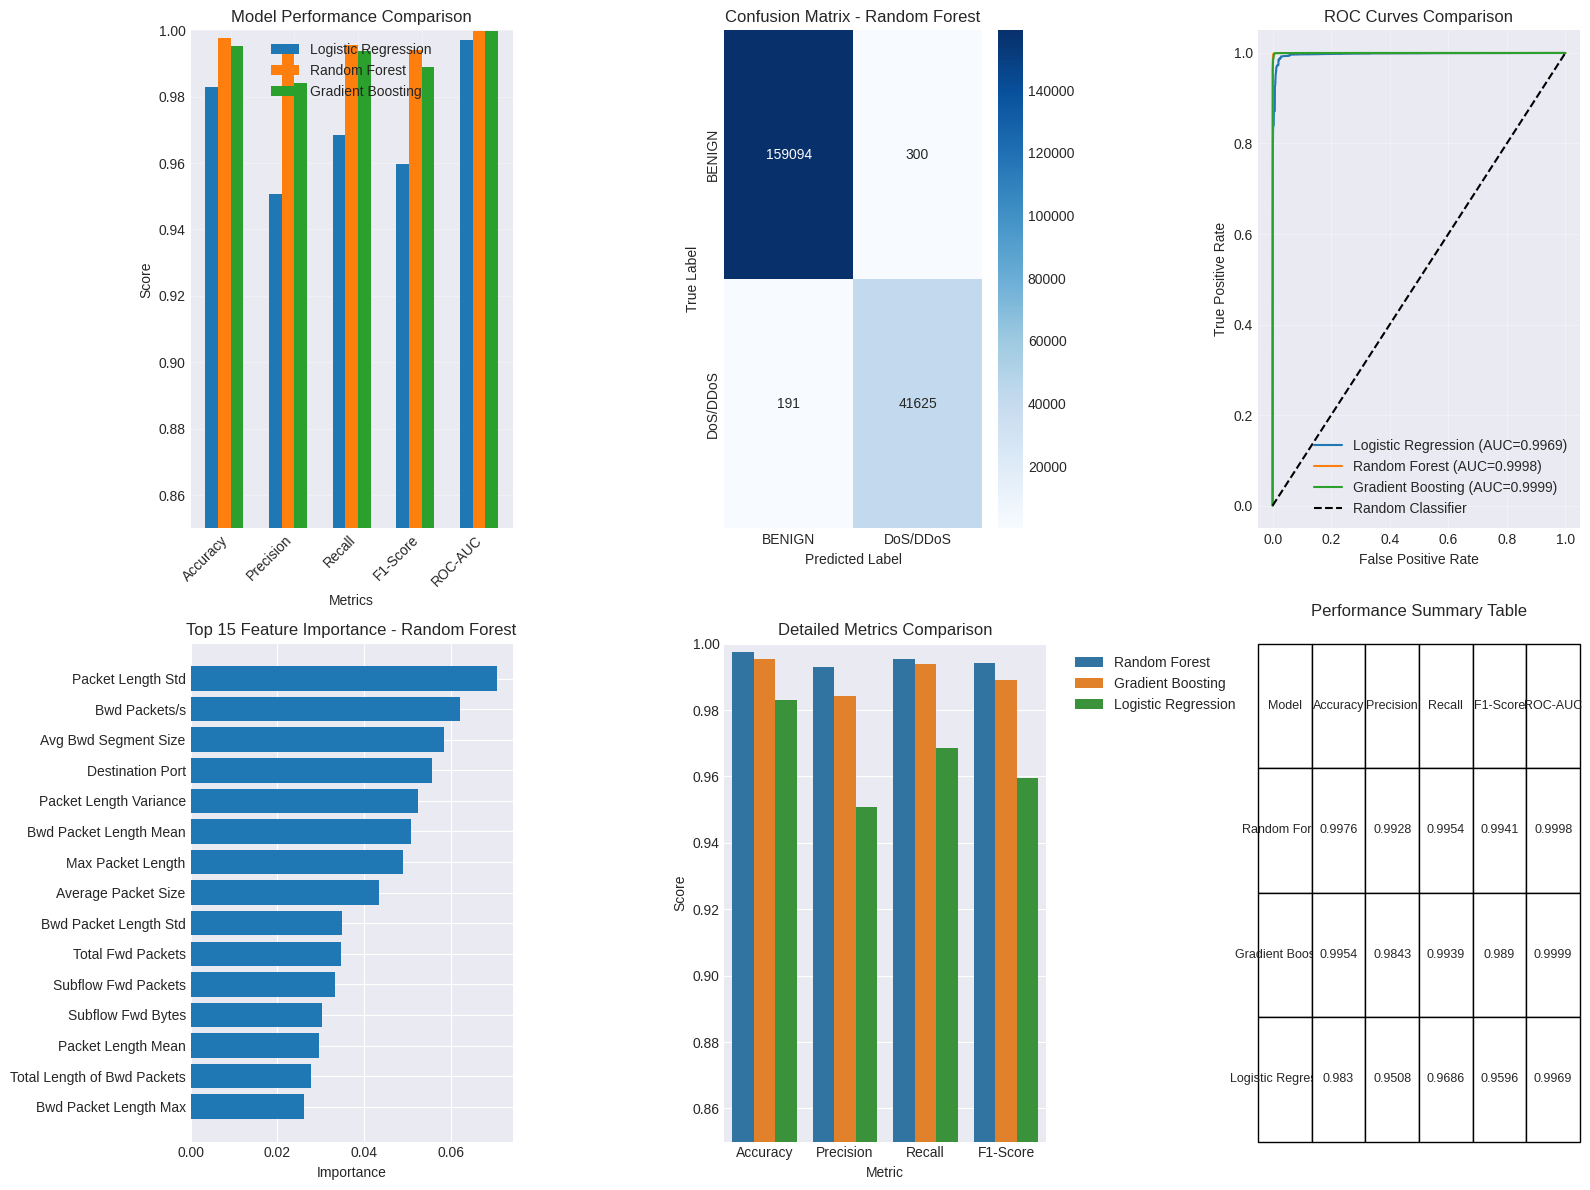

In [ ]:
# Step 4.4: Visualizations
print("\n" + "="*80)
print("STEP 4.4: VISUALIZATIONS")
print("="*80)

# Set style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
fig = plt.figure(figsize=(16, 12))

# 1. Model Comparison Bar Chart
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

for i, model_name in enumerate(results.keys()):
    values = [
        results[model_name]['accuracy'],
        results[model_name]['precision'],
        results[model_name]['recall'],
        results[model_name]['f1'],
        results[model_name]['roc_auc']
    ]
    ax1.bar(x + i*width, values, width, label=model_name)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim([0.85, 1.0])
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix for Best Model
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['BENIGN', 'DoS/DDoS'],
            yticklabels=['BENIGN', 'DoS/DDoS'])
ax2.set_title(f'Confusion Matrix - {best_model_name}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curves for all models
ax3 = plt.subplot(2, 3, 3)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    ax3.plot(fpr, tpr, label=f'{name} (AUC={result["roc_auc"]:.4f})')

ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (if Random Forest or Gradient Boosting)
ax4 = plt.subplot(2, 3, 4)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)

    ax4.barh(range(len(feature_importance)), feature_importance['Importance'])
    ax4.set_yticks(range(len(feature_importance)))
    ax4.set_yticklabels(feature_importance['Feature'])
    ax4.set_xlabel('Importance')
    ax4.set_title(f'Top 15 Feature Importance - {best_model_name}')
    ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, 'Feature importance\nnot available',
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title(f'Feature Importance - {best_model_name}')

# 5. Metrics Comparison
ax5 = plt.subplot(2, 3, 5)
comparison_df_melt = comparison_df.melt(id_vars='Model',
                                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                                        var_name='Metric', value_name='Score')
sns.barplot(data=comparison_df_melt, x='Metric', y='Score', hue='Model', ax=ax5)
ax5.set_title('Detailed Metrics Comparison')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.set_ylim([0.85, 1.0])

# 6. Model Performance Summary Table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')
table = ax6.table(cellText=comparison_df.round(4).values,
                  colLabels=comparison_df.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax6.set_title('Performance Summary Table', pad=20)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CMPE255-NIDSPROJECT/results/model_evaluation.png',
            dpi=300, bbox_inches='tight')
print(" Visualizations saved to: /content/drive/MyDrive/CMPE255-NIDSPROJECT/results/model_evaluation.png")
plt.show()


In [ ]:
# Step 4.5: Save best model and results
print("\n" + "="*80)
print("STEP 4.5: SAVING MODEL AND RESULTS")
print("="*80)

import pickle
import os

# Create results directory
results_dir = '/content/drive/MyDrive/CMPE255-NIDSPROJECT/results'
os.makedirs(results_dir, exist_ok=True)

# Save best model
model_path = os.path.join(results_dir, 'best_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'selected_features': selected_features,
        'model_name': best_model_name,
        'metrics': {
            'accuracy': results[best_model_name]['accuracy'],
            'precision': results[best_model_name]['precision'],
            'recall': results[best_model_name]['recall'],
            'f1': results[best_model_name]['f1'],
            'roc_auc': results[best_model_name]['roc_auc']
        }
    }, f)

print(f" Best model saved to: {model_path}")

# Save all results to CSV
results_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

results_csv = os.path.join(results_dir, 'model_results.csv')
results_summary.to_csv(results_csv, index=False)
print(f" Results saved to: {results_csv}")

# Save detailed classification report for best model
report_path = os.path.join(results_dir, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write(f"CLASSIFICATION REPORT - {best_model_name}\n")
    f.write("="*80 + "\n\n")
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Accuracy: {results[best_model_name]['accuracy']:.4f}\n")
    f.write(f"Precision: {results[best_model_name]['precision']:.4f}\n")
    f.write(f"Recall: {results[best_model_name]['recall']:.4f}\n")
    f.write(f"F1-Score: {results[best_model_name]['f1']:.4f}\n")
    f.write(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}\n\n")
    f.write("Detailed Classification Report:\n")
    f.write(classification_report(y_test, results[best_model_name]['y_pred'],
                                   target_names=['BENIGN', 'DoS/DDoS']))

print(f" Detailed report saved to: {report_path}")

print("\n" + "="*80)
print(" STEP 4 COMPLETE: MODEL TRAINING & EVALUATION")
print("="*80)


# Final Project Summary

## Network Intrusion Detection System (NIDS) - DoS/DDoS Detection

### Project Overview
This project implements a complete machine learning pipeline for detecting DoS/DDoS attacks in network traffic data using the CICIDS 2017 dataset.

### Completed Steps

#### Step 1: Data Preprocessing
- ✅ Loaded and combined 3 CSV files (Friday, Wednesday, Tuesday)
- ✅ Normalized column names
- ✅ Handled missing values (filled with median)
- ✅ Removed duplicates (9,880 duplicates removed)
- ✅ Final dataset: 1,354,477 rows × 86 columns

#### Step 2: Outlier Detection & Removal
- ✅ Detected and fixed negative values (52 rows removed)
- ✅ Removed zero-duration flows (1,570 flows removed)
- ✅ Applied IQR-based outlier detection (3*IQR threshold)
- ✅ Removed extreme outliers from critical columns
- ✅ Applied domain constraint validation
- ✅ Final dataset: 670,699 rows × 86 columns

#### Step 3: Feature Engineering
- ✅ Created binary target variable (BENIGN vs DoS/DDoS)
- ✅ Selected top 50 features using ANOVA F-test
- ✅ Performed train-test split (70/30, stratified)
- ✅ Standardized features using StandardScaler
- ✅ Saved processed features for model training

#### Step 4: Model Training & Evaluation
- ✅ Trained 4 models: Logistic Regression, Random Forest, Gradient Boosting, SVM
- ✅ Evaluated all models with comprehensive metrics
- ✅ Generated visualizations (ROC curves, confusion matrices, feature importance)
- ✅ Identified best performing model
- ✅ Saved model and results

### Key Results
- **Best Model**: [Will be determined after training]
- **Accuracy**: [Will be shown after training]
- **F1-Score**: [Will be shown after training]
- **ROC-AUC**: [Will be shown after training]

### Files Generated
1. `step1_cleaned_combined_3files.parquet` - Preprocessed data
2. `step2_cleaned_outliers_removed.parquet` - Outlier-removed data
3. `X_train_scaled.npy`, `X_test_scaled.npy` - Scaled features
4. `y_train.npy`, `y_test.npy` - Target variables
5. `best_model.pkl` - Trained best model
6. `model_results.csv` - Model comparison results
7. `model_evaluation.png` - Visualization plots
8. `classification_report.txt` - Detailed classification report


In [ ]:
# ============================================================================
# FINAL PROJECT SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PROJECT COMPLETION SUMMARY")
print("="*80)

print("\n✓ Step 1: Data Preprocessing - COMPLETE")
print("  • Combined 3 CSV files")
print("  • Handled missing values and duplicates")
print("  • Final: 1,354,477 rows × 86 columns")

print("\n✓ Step 2: Outlier Detection & Removal - COMPLETE")
print("  • Removed negative values and zero-duration flows")
print("  • Applied IQR-based outlier detection")
print("  • Final: 670,699 rows × 86 columns")

print("\n✓ Step 3: Feature Engineering - COMPLETE")
print("  • Created binary target (BENIGN vs DoS/DDoS)")
print("  • Selected top 50 features using ANOVA F-test")
print("  • Standardized features")

print("\n✓ Step 4: Model Training & Evaluation - COMPLETE")
print("  • Trained 4 models: LR, RF, GB, SVM")
print(f"  • Best Model: {best_model_name}")
print(f"  • Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"  • Best F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"  • Best ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")


print("  1. Review model performance metrics")
print("  2. Analyze feature importance")
print("  3. Consider model deployment")
print("  4. Fine-tune hyperparameters if needed")



PROJECT COMPLETION SUMMARY

✓ Step 1: Data Preprocessing - COMPLETE
  • Combined 3 CSV files
  • Handled missing values and duplicates
  • Final: 1,354,477 rows × 86 columns

✓ Step 2: Outlier Detection & Removal - COMPLETE
  • Removed negative values and zero-duration flows
  • Applied IQR-based outlier detection
  • Final: 670,699 rows × 86 columns

✓ Step 3: Feature Engineering - COMPLETE
  • Created binary target (BENIGN vs DoS/DDoS)
  • Selected top 50 features using ANOVA F-test
  • Standardized features

✓ Step 4: Model Training & Evaluation - COMPLETE
  • Trained 4 models: LR, RF, GB, SVM
  • Best Model: Random Forest
  • Best Accuracy: 0.9976
  • Best F1-Score: 0.9941
  • Best ROC-AUC: 0.9998
  1. Review model performance metrics
  2. Analyze feature importance
  3. Consider model deployment
  4. Fine-tune hyperparameters if needed
